## Imports

In [69]:
# Native libraries
import time
import copy
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore")

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 42

https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering

## 1. ETL (Extract, Transform, Load)

In [3]:
df = pd.read_csv('datasets/all_2000_user_means.csv')
df

,MeterID,user,0,1,2,3,4,5,6,7,...,86,87,88,89,90,91,92,93,94,95
0,6200093839,0,0.793782,0.806860,0.800848,0.788947,0.789313,0.767975,0.769679,0.751206,...,0.722720,0.734066,0.751667,0.778778,0.795844,0.789346,0.794778,0.796082,0.792325,0.796008
1,6200093048,1,0.041691,0.042938,0.042560,0.041551,0.040790,0.040354,0.040226,0.039733,...,0.059342,0.057185,0.055041,0.052202,0.048926,0.047021,0.045280,0.043815,0.043263,0.042198
2,6200085183,2,0.114519,0.118584,0.116782,0.111737,0.112181,0.107630,0.108683,0.102934,...,0.151885,0.144255,0.135827,0.131691,0.126115,0.126082,0.124058,0.121074,0.119366,0.117086
3,6200059982,3,0.170506,0.165831,0.153872,0.142395,0.133942,0.130494,0.126901,0.127193,...,0.287523,0.279782,0.272053,0.254453,0.237963,0.229202,0.223638,0.216510,0.204082,0.184267
4,6200063890,4,0.097938,0.094436,0.096247,0.095243,0.092761,0.095033,0.092370,0.091309,...,0.101358,0.100169,0.100313,0.099770,0.096185,0.098502,0.098309,0.099757,0.097309,0.099914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,6200050860,1996,0.388585,0.399708,0.394156,0.391014,0.385222,0.376538,0.372198,0.371741,...,0.538863,0.505590,0.465703,0.451953,0.434585,0.422505,0.413858,0.403651,0.400792,0.395939
1997,6200050862,1997,0.411028,0.411231,0.400396,0.385151,0.369099,0.356368,0.339241,0.323774,...,0.577495,0.568868,0.558321,0.547684,0.528708,0.505189,0.478264,0.451571,0.438967,0.429226
1998,6200050858,1998,0.019802,0.020330,0.019755,0.020316,0.021354,0.021226,0.020292,0.018448,...,0.015090,0.016047,0.016585,0.017274,0.018769,0.019693,0.019604,0.019368,0.018774,0.019335
1999,6200051042,1999,0.071825,0.070642,0.068693,0.068222,0.066439,0.062396,0.062038,0.062245,...,0.173613,0.149509,0.132335,0.117524,0.105542,0.095198,0.088802,0.081585,0.074769,0.074816


In [4]:
noise = pd.read_csv('datasets/noise_users.csv')
noise

,Series,Cluster
0,442,Cluster 19
1,1856,Cluster 19
2,1634,Cluster 19
3,1280,Cluster 19
4,1310,Cluster 19
...,...,...
158,658,Cluster 44
159,1621,Cluster 44
160,922,Cluster 44
161,716,Cluster 44


In [5]:
df = df[~df['user'].isin(noise['Series'])]
df['user'].nunique()

1838

In [6]:
df = df.drop(columns=['MeterID'])
df = df.set_index('user')
df

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
user,,,,,,,,,,,,,,,,,,,,,
0,0.793782,0.806860,0.800848,0.788947,0.789313,0.767975,0.769679,0.751206,0.746905,0.736597,...,0.722720,0.734066,0.751667,0.778778,0.795844,0.789346,0.794778,0.796082,0.792325,0.796008
1,0.041691,0.042938,0.042560,0.041551,0.040790,0.040354,0.040226,0.039733,0.039099,0.039115,...,0.059342,0.057185,0.055041,0.052202,0.048926,0.047021,0.045280,0.043815,0.043263,0.042198
2,0.114519,0.118584,0.116782,0.111737,0.112181,0.107630,0.108683,0.102934,0.102909,0.106366,...,0.151885,0.144255,0.135827,0.131691,0.126115,0.126082,0.124058,0.121074,0.119366,0.117086
3,0.170506,0.165831,0.153872,0.142395,0.133942,0.130494,0.126901,0.127193,0.128588,0.133576,...,0.287523,0.279782,0.272053,0.254453,0.237963,0.229202,0.223638,0.216510,0.204082,0.184267
4,0.097938,0.094436,0.096247,0.095243,0.092761,0.095033,0.092370,0.091309,0.092840,0.096049,...,0.101358,0.100169,0.100313,0.099770,0.096185,0.098502,0.098309,0.099757,0.097309,0.099914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.388585,0.399708,0.394156,0.391014,0.385222,0.376538,0.372198,0.371741,0.372014,0.365712,...,0.538863,0.505590,0.465703,0.451953,0.434585,0.422505,0.413858,0.403651,0.400792,0.395939
1997,0.411028,0.411231,0.400396,0.385151,0.369099,0.356368,0.339241,0.323774,0.306066,0.300967,...,0.577495,0.568868,0.558321,0.547684,0.528708,0.505189,0.478264,0.451571,0.438967,0.429226
1998,0.019802,0.020330,0.019755,0.020316,0.021354,0.021226,0.020292,0.018448,0.018481,0.019406,...,0.015090,0.016047,0.016585,0.017274,0.018769,0.019693,0.019604,0.019368,0.018774,0.019335


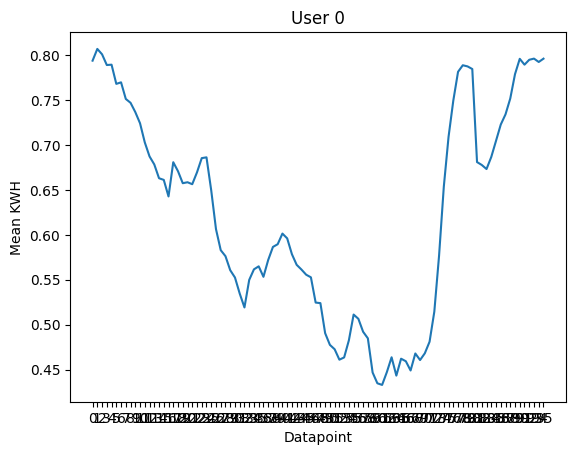

In [7]:
# Select row for user 0
user0_data = df.loc[0]

plt.plot(user0_data.index, user0_data.values)
plt.xlabel('Datapoint')
plt.ylabel('Mean KWH')
plt.title('User 0')
plt.show()

In [8]:
df_test = df.copy()
df_test

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
user,,,,,,,,,,,,,,,,,,,,,
0,0.793782,0.806860,0.800848,0.788947,0.789313,0.767975,0.769679,0.751206,0.746905,0.736597,...,0.722720,0.734066,0.751667,0.778778,0.795844,0.789346,0.794778,0.796082,0.792325,0.796008
1,0.041691,0.042938,0.042560,0.041551,0.040790,0.040354,0.040226,0.039733,0.039099,0.039115,...,0.059342,0.057185,0.055041,0.052202,0.048926,0.047021,0.045280,0.043815,0.043263,0.042198
2,0.114519,0.118584,0.116782,0.111737,0.112181,0.107630,0.108683,0.102934,0.102909,0.106366,...,0.151885,0.144255,0.135827,0.131691,0.126115,0.126082,0.124058,0.121074,0.119366,0.117086
3,0.170506,0.165831,0.153872,0.142395,0.133942,0.130494,0.126901,0.127193,0.128588,0.133576,...,0.287523,0.279782,0.272053,0.254453,0.237963,0.229202,0.223638,0.216510,0.204082,0.184267
4,0.097938,0.094436,0.096247,0.095243,0.092761,0.095033,0.092370,0.091309,0.092840,0.096049,...,0.101358,0.100169,0.100313,0.099770,0.096185,0.098502,0.098309,0.099757,0.097309,0.099914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.388585,0.399708,0.394156,0.391014,0.385222,0.376538,0.372198,0.371741,0.372014,0.365712,...,0.538863,0.505590,0.465703,0.451953,0.434585,0.422505,0.413858,0.403651,0.400792,0.395939
1997,0.411028,0.411231,0.400396,0.385151,0.369099,0.356368,0.339241,0.323774,0.306066,0.300967,...,0.577495,0.568868,0.558321,0.547684,0.528708,0.505189,0.478264,0.451571,0.438967,0.429226
1998,0.019802,0.020330,0.019755,0.020316,0.021354,0.021226,0.020292,0.018448,0.018481,0.019406,...,0.015090,0.016047,0.016585,0.017274,0.018769,0.019693,0.019604,0.019368,0.018774,0.019335


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Loop over the rows of the pivoted dataframe
for index, row in df_test.iterrows():
    
    # Extract the time series data from the row
    data = row.values.reshape(-1, 1)
    
    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)
    
    # Replace the original data with the normalized data
    df_test.loc[index] = data_normalized.flatten()

In [10]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
user,,,,,,,,,,,,,,,,,,,,,
0,0.965017,1.000000,0.983917,0.952082,0.953062,0.895985,0.900543,0.851128,0.839624,0.812049,...,0.774930,0.805279,0.852361,0.924881,0.970532,0.953150,0.967681,0.971170,0.961120,0.970972
1,0.053752,0.075910,0.069182,0.051265,0.037736,0.029984,0.027717,0.018941,0.007679,0.007971,...,0.367413,0.329092,0.290990,0.240529,0.182317,0.148457,0.117522,0.091487,0.081688,0.062747
2,0.183432,0.206546,0.196299,0.167618,0.170145,0.144271,0.150260,0.117578,0.117438,0.137089,...,0.395850,0.352477,0.304567,0.281056,0.249357,0.249170,0.237660,0.220699,0.210991,0.198030
3,0.158932,0.142264,0.099626,0.058704,0.028567,0.016272,0.003463,0.004504,0.009478,0.027261,...,0.576143,0.548544,0.520989,0.458235,0.399442,0.368205,0.348368,0.322955,0.278644,0.207996
4,0.006244,0.003043,0.004698,0.003780,0.001512,0.003589,0.001155,0.000184,0.001584,0.004518,...,0.009370,0.008283,0.008415,0.007918,0.004642,0.006760,0.006583,0.007907,0.005669,0.008050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.125294,0.160004,0.142678,0.132875,0.114799,0.087700,0.074158,0.072730,0.073584,0.053918,...,0.594250,0.490417,0.365947,0.323039,0.268841,0.231144,0.204163,0.172309,0.163389,0.148242
1997,0.402743,0.403273,0.374971,0.335149,0.293220,0.259965,0.215227,0.174825,0.128572,0.115252,...,0.837570,0.815034,0.787484,0.759700,0.710132,0.648698,0.578369,0.508643,0.475721,0.450278
1998,0.844738,0.897593,0.840019,0.896177,1.000000,0.987258,0.893818,0.709297,0.712600,0.805097,...,0.373289,0.469089,0.522888,0.591789,0.741387,0.833884,0.824917,0.801321,0.741859,0.798018


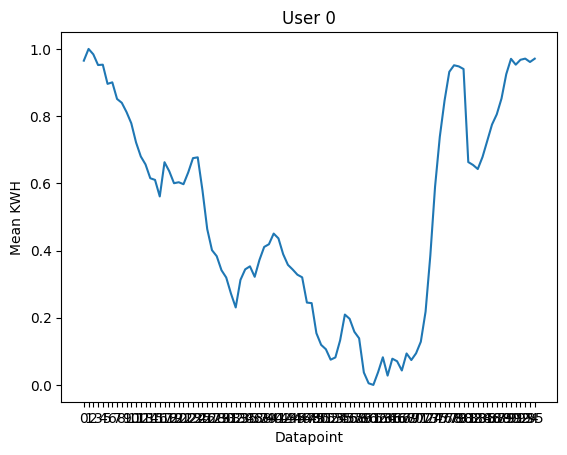

In [11]:
# After Normalized
# Select row for user 0
user0_data = df_test.loc[0]

plt.plot(user0_data.index, user0_data.values)
plt.xlabel('Datapoint')
plt.ylabel('Mean KWH')
plt.title('User 0')
plt.show()

In [12]:
for index, row in df_test.iterrows():
    print(f'MeterID {index}: min = {row.min()}, max = {row.max()}')

MeterID 0: min = 0.0, max = 1.0
MeterID 1: min = 0.0, max = 0.9999999999999999
MeterID 2: min = 0.0, max = 1.0
MeterID 3: min = 0.0, max = 1.0
MeterID 4: min = 0.0, max = 1.0
MeterID 6: min = 0.0, max = 1.0000000000000002
MeterID 7: min = 0.0, max = 0.9999999999999999
MeterID 8: min = 0.0, max = 1.0000000000000002
MeterID 9: min = 0.0, max = 1.0
MeterID 10: min = 0.0, max = 1.0
MeterID 11: min = 0.0, max = 1.0
MeterID 12: min = 0.0, max = 1.0
MeterID 13: min = 0.0, max = 1.0
MeterID 14: min = 0.0, max = 1.0
MeterID 15: min = 0.0, max = 1.0
MeterID 16: min = 0.0, max = 1.0
MeterID 17: min = 0.0, max = 1.0
MeterID 18: min = 0.0, max = 1.0
MeterID 19: min = 0.0, max = 0.9999999999999999
MeterID 20: min = 0.0, max = 1.0
MeterID 21: min = 0.0, max = 1.0
MeterID 22: min = 0.0, max = 0.9999999999999998
MeterID 23: min = 0.0, max = 1.0
MeterID 24: min = 0.0, max = 1.0
MeterID 25: min = 0.0, max = 0.9999999999999999
MeterID 26: min = 0.0, max = 1.0
MeterID 27: min = 0.0, max = 1.0
MeterID 28: m

In [15]:
from tqdm import tqdm
import math
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_count = math.ceil(math.sqrt(len(df_test))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN
print(cluster_count)

n_clusters = range(2, cluster_count)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in tqdm(n_clusters):
    # Build model
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=-1, random_state=42)
    # Train model
    km.fit(df_test)
    # Calculate inertia
    inertia_errors.append(km.inertia_)
    # Calculate ss
    silhouette_scores.append(silhouette_score(df_test, km.labels_))
    
print("Inertia:", inertia_errors)
print()
print("Silhouette Scores:", silhouette_scores)

43


100%|██████████| 41/41 [1:21:29<00:00, 119.27s/it]

Inertia: [0.6510859292843681, 0.519499913894115, 0.46149495617711983, 0.4178460146679835, 0.39302173449568617, 0.3615194670439121, 0.3511749173451276, 0.3388307757702791, 0.32625004949501357, 0.32027666591711224, 0.31771344747677616, 0.3109382643766185, 0.30477691697898557, 0.29957470607199627, 0.29408804515388254, 0.2892384545718245, 0.2865491367745696, 0.28281805759292533, 0.2808792488679233, 0.2765911973060937, 0.2709861025726757, 0.26864674774629793, 0.2625865471699162, 0.25892203933641544, 0.2571296378401837, 0.2534726882269974, 0.25306744182113206, 0.2505915048985718, 0.2482440038458976, 0.24545161296245843, 0.2424754101196817, 0.2417557552397984, 0.24008551876305, 0.23871159289289734, 0.23729998332596772, 0.2355997665328932, 0.233581857577878, 0.23120703826344535, 0.23021417195213725, 0.2300677389408213, 0.22769781294817792]

Silhouette Scores: [0.20251693460461245, 0.09899458949978954, 0.06797207776075115, 0.06206397604611428, 0.033833889469557454, 0.03377874770784061, 0.022117

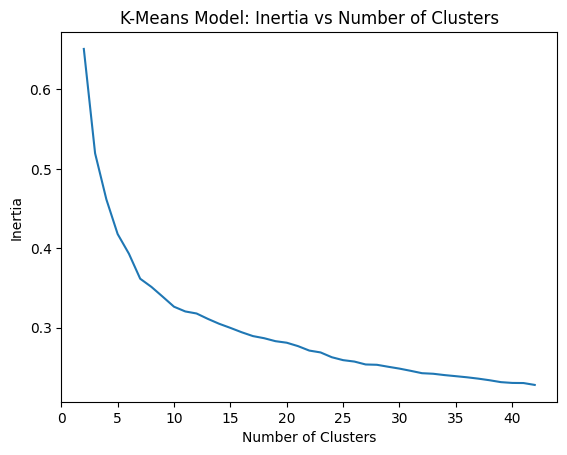

In [22]:
# Plot `inertia_errors` by `n_clusters`
plt.plot(n_clusters, inertia_errors)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("K-Means Model: Inertia vs Number of Clusters");

# Save plot
# plt.savefig('figure/K-Means_Model_Inertia.jpeg')
# print("Save Figure sucessfully")

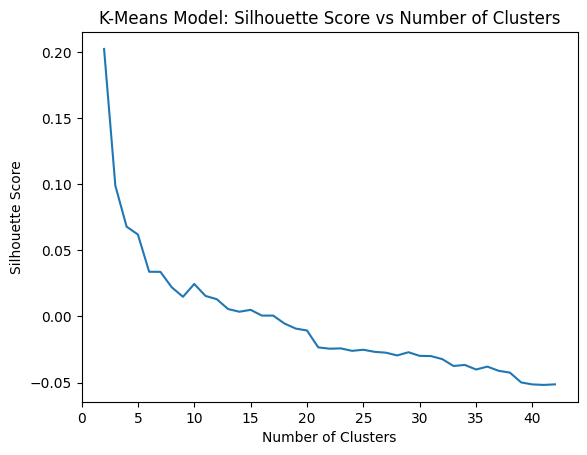

In [21]:
# Plot `silhouette_scores` vs `n_clusters`
plt.plot(n_clusters, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("K-Means Model: Silhouette Score vs Number of Clusters");

# Save plot
# plt.savefig('figure/K-Means_Model_Silhouette_Score.jpeg')
# print("Save Figure sucessfully")

In [23]:
# inertia = km.inertia_
# print("Inertia (45 clusters):", inertia)

The "best" inertia is 0, and our score is pretty far from that. Does that mean our model is "bad?" Not necessarily. Inertia is a measurement of distance (like mean absolute error). This means that the unit of measurement for inertia depends on the unit of measurement of our x- and y-axes.

However, it would be helpful to have metric that was easier to interpret, and that's where **silhouette score** comes in. Silhouette score measures the distance between different clusters. It ranges from -1 (the worst) to 1 (the best), so it's easier to interpret than inertia.

In [24]:
# ss = silhouette_score(df_test, km.labels_)
# print("Silhouette Score (45 clusters):", ss)

It's important to remember that these performance metrics are the result of the number of clusters we told our model to create. In unsupervised learning, the number of clusters is hyperparameter that you set before training your model. So what would happen if we change the number of clusters? Will it lead to better performance? Let's try!

## Model

### K=5

In [76]:
km = TimeSeriesKMeans(n_clusters=5, metric="dtw", n_jobs=-1, random_state=42)

labels = km.fit_predict(df_test)  #Index of the cluster each sample belongs to.

print("Inertia (5 clusters):", km.inertia_)

ss = silhouette_score(df_test, km.labels_)
print("Silhouette Score (5 clusters):", ss)

Inertia (5 clusters): 0.4178460146679835
Silhouette Score (5 clusters): 0.06206397604611428


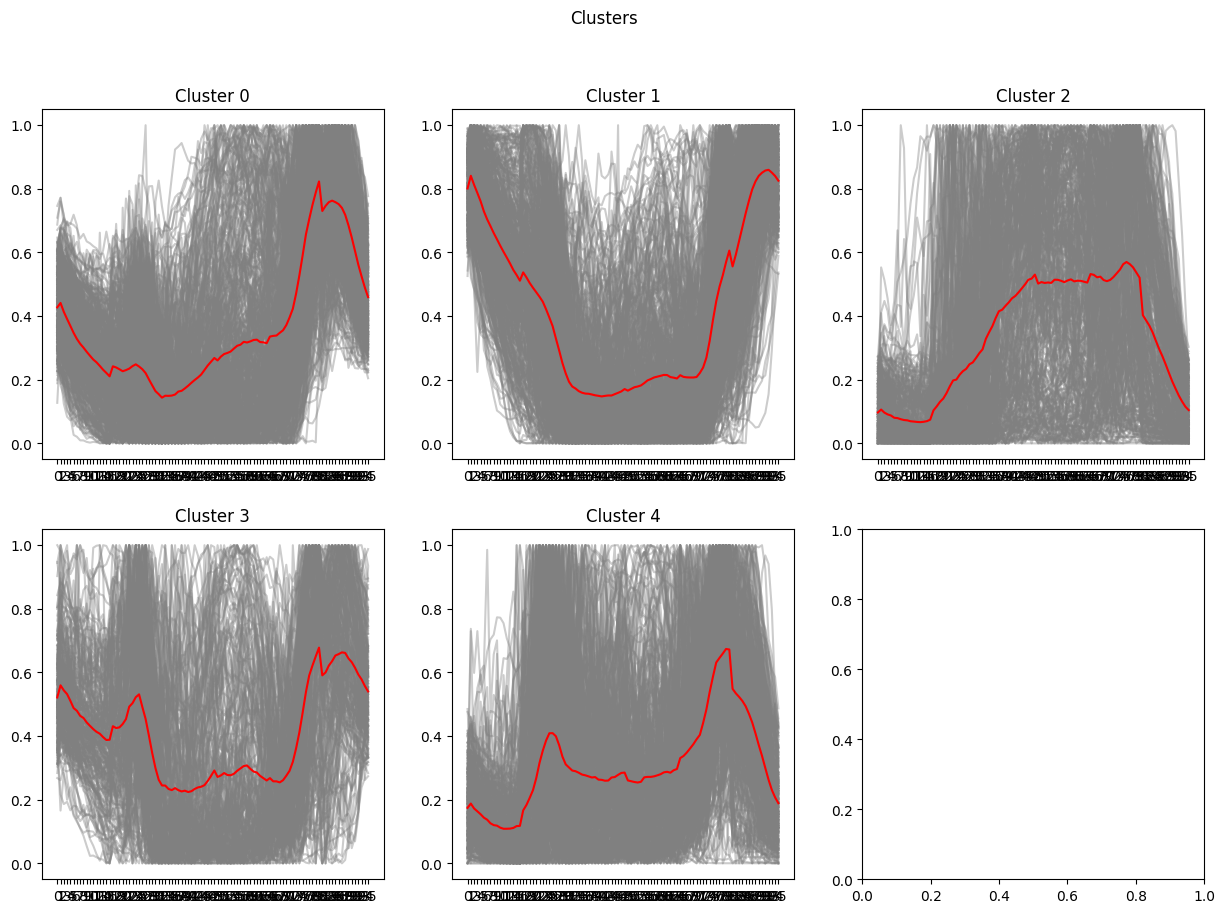

In [77]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Clusters')
row_i = 0
column_j = 0

for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if(labels[i] == label):
            axs[row_i, column_j].plot(df_test.iloc[i], c="gray", alpha=0.4)
            cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*3+column_j))
    column_j += 1
    if column_j % 3 == 0:
        row_i += 1
        column_j = 0

plt.show()

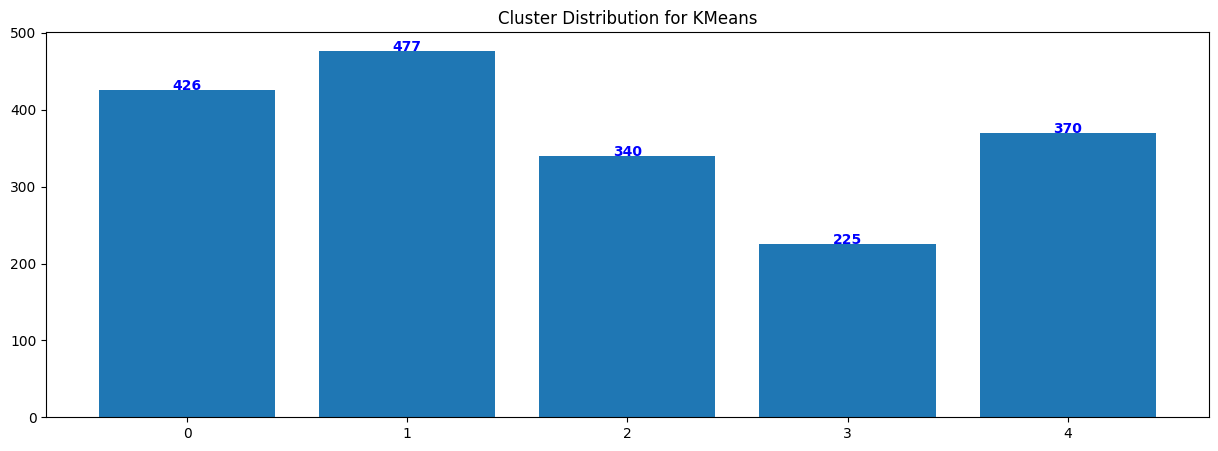

In [78]:
# Cluster Distribution
cluster_c = [len(labels[labels==i]) for i in range(5)]
# cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
cluster_n = [str(i) for i in range(5)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
for i, v in enumerate(cluster_c):
    plt.text(i, v, str(v), color='blue', fontweight='bold', ha='center')
plt.show()

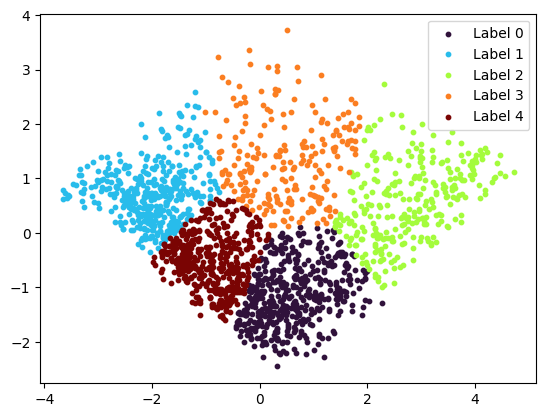

In [82]:
# Curse of Dimensionality

pca = PCA(n_components=2)
mySeries_transformed = pca.fit_transform(df_test)

kmeans = KMeans(n_clusters=5, max_iter=500)
labels = kmeans.fit_predict(mySeries_transformed)

# Create a list of unique labels
unique_labels = list(set(labels))

# Set the colormap to match the number of labels
cmap = plt.cm.get_cmap('turbo', len(unique_labels))

# Plot each label separately with a different color and a label string
for i, label in enumerate(unique_labels):
    plt.scatter(mySeries_transformed[labels == label, 0], mySeries_transformed[labels == label, 1],
                c=cmap(i), s=10, label="Label {}".format(label))

# Add a legend to the plot
plt.legend()
plt.show()

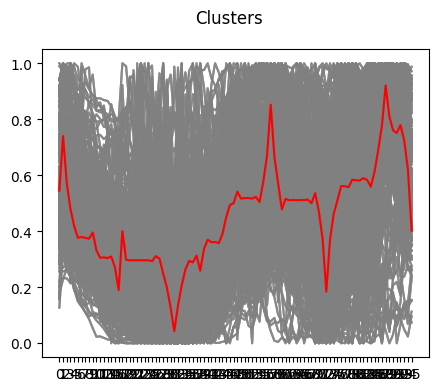

In [84]:
# Check Cluster
Cluster = 3
fig, axs = plt.subplots(1,1,figsize=(5,4))
fig.suptitle('Clusters')
# row_i=0
# column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==Cluster):
                axs.plot(df_test.iloc[i],c="gray",alpha=0.4)
                cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs.plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")

plt.show()

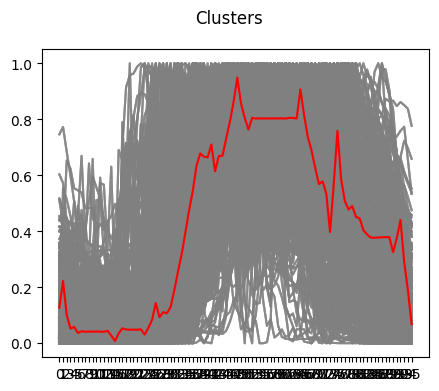

In [85]:
# Check Cluster
Cluster = 2
fig, axs = plt.subplots(1,1,figsize=(5,4))
fig.suptitle('Clusters')
# row_i=0
# column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==Cluster):
                axs.plot(df_test.iloc[i],c="gray",alpha=0.4)
                cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs.plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")

plt.show()

### K=6

In [86]:
km = TimeSeriesKMeans(n_clusters=6, metric="dtw", n_jobs=-1, random_state=42)

labels = km.fit_predict(df_test)  #Index of the cluster each sample belongs to.

print("Inertia (6 clusters):", km.inertia_)

ss = silhouette_score(df_test, km.labels_)
print("Silhouette Score (6 clusters):", ss)

Inertia (6 clusters): 0.39302173449568617
Silhouette Score (6 clusters): 0.033833889469557454


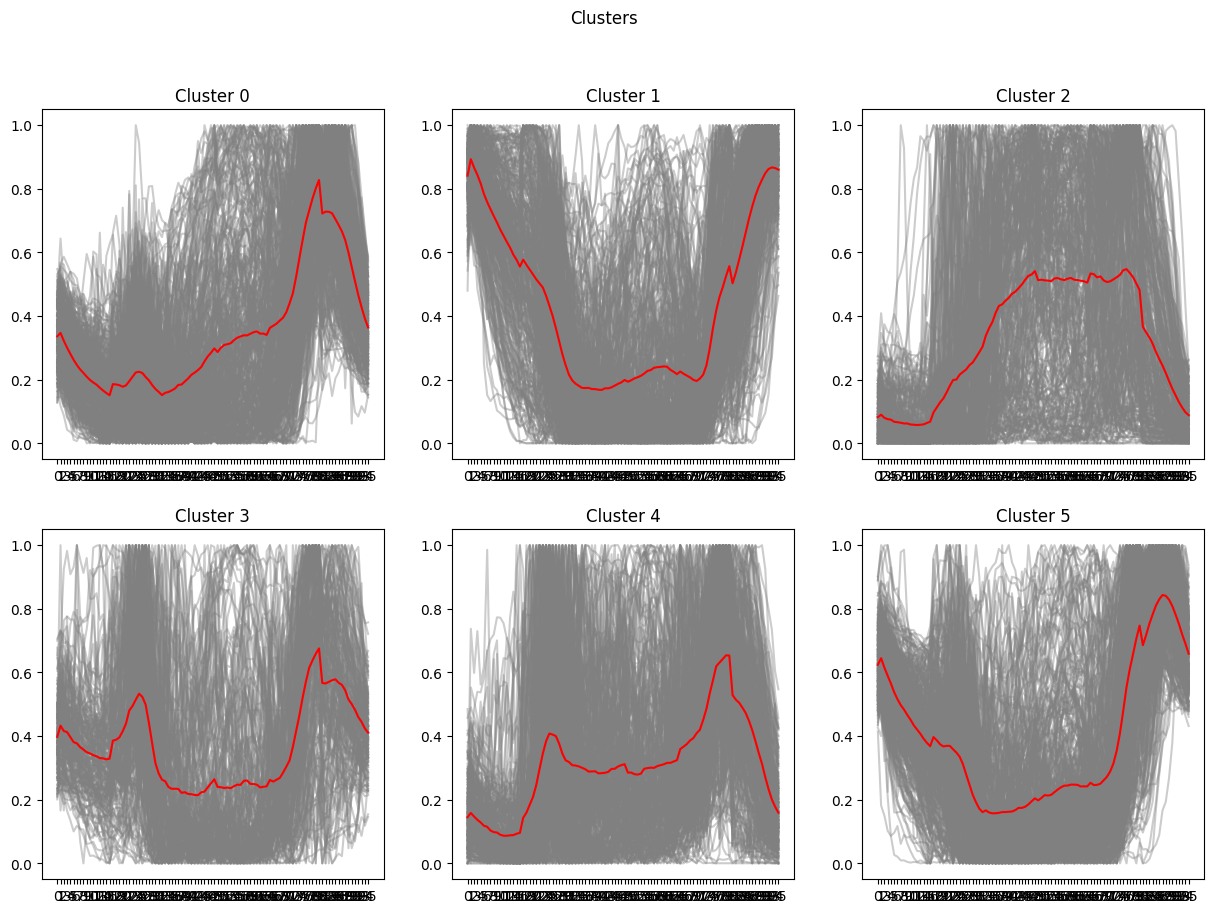

In [87]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Clusters')
row_i = 0
column_j = 0

for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if(labels[i] == label):
            axs[row_i, column_j].plot(df_test.iloc[i], c="gray", alpha=0.4)
            cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*3+column_j))
    column_j += 1
    if column_j % 3 == 0:
        row_i += 1
        column_j = 0

plt.show()

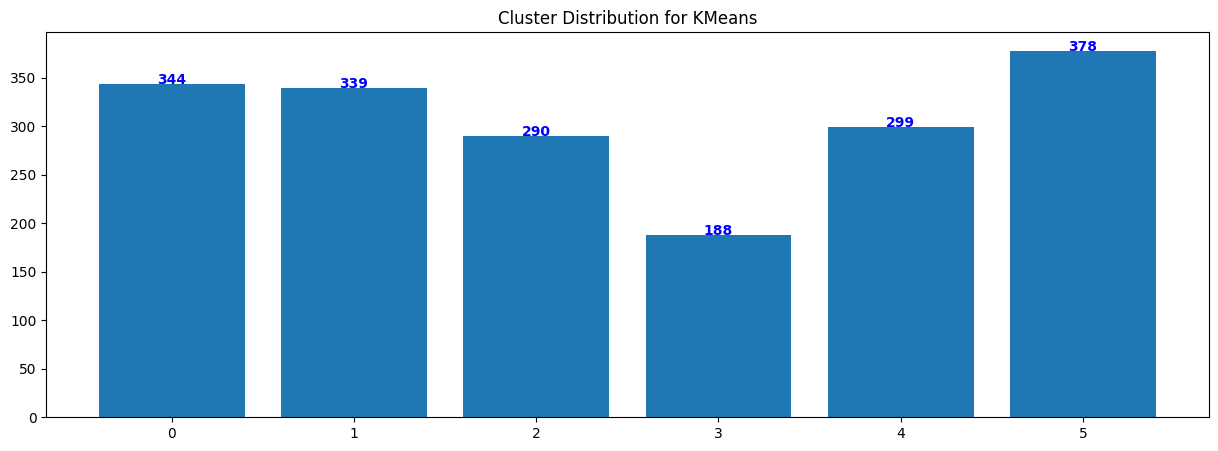

In [88]:
# Cluster Distribution
cluster_c = [len(labels[labels==i]) for i in range(6)]
# cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
cluster_n = [str(i) for i in range(6)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
for i, v in enumerate(cluster_c):
    plt.text(i, v, str(v), color='blue', fontweight='bold', ha='center')
plt.show()

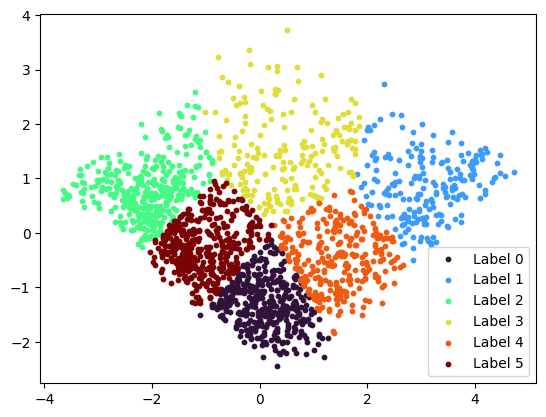

In [89]:
# Curse of Dimensionality

pca = PCA(n_components=2)
mySeries_transformed = pca.fit_transform(df_test)

kmeans = KMeans(n_clusters=6, max_iter=500)
labels = kmeans.fit_predict(mySeries_transformed)

# Create a list of unique labels
unique_labels = list(set(labels))

# Set the colormap to match the number of labels
cmap = plt.cm.get_cmap('turbo', len(unique_labels))

# Plot each label separately with a different color and a label string
for i, label in enumerate(unique_labels):
    plt.scatter(mySeries_transformed[labels == label, 0], mySeries_transformed[labels == label, 1],
                c=cmap(i), s=10, label="Label {}".format(label))

# Add a legend to the plot
plt.legend()
plt.show()

### K=7

In [65]:
km = TimeSeriesKMeans(n_clusters=7, metric="dtw", n_jobs=-1, random_state=42)

labels = km.fit_predict(df_test)  #Index of the cluster each sample belongs to.

print("Inertia (7 clusters):", km.inertia_)

ss = silhouette_score(df_test, km.labels_)
print("Silhouette Score (7 clusters):", ss)

Inertia (7 clusters): 0.3615194670439121
Silhouette Score (7 clusters): 0.03377874770784061


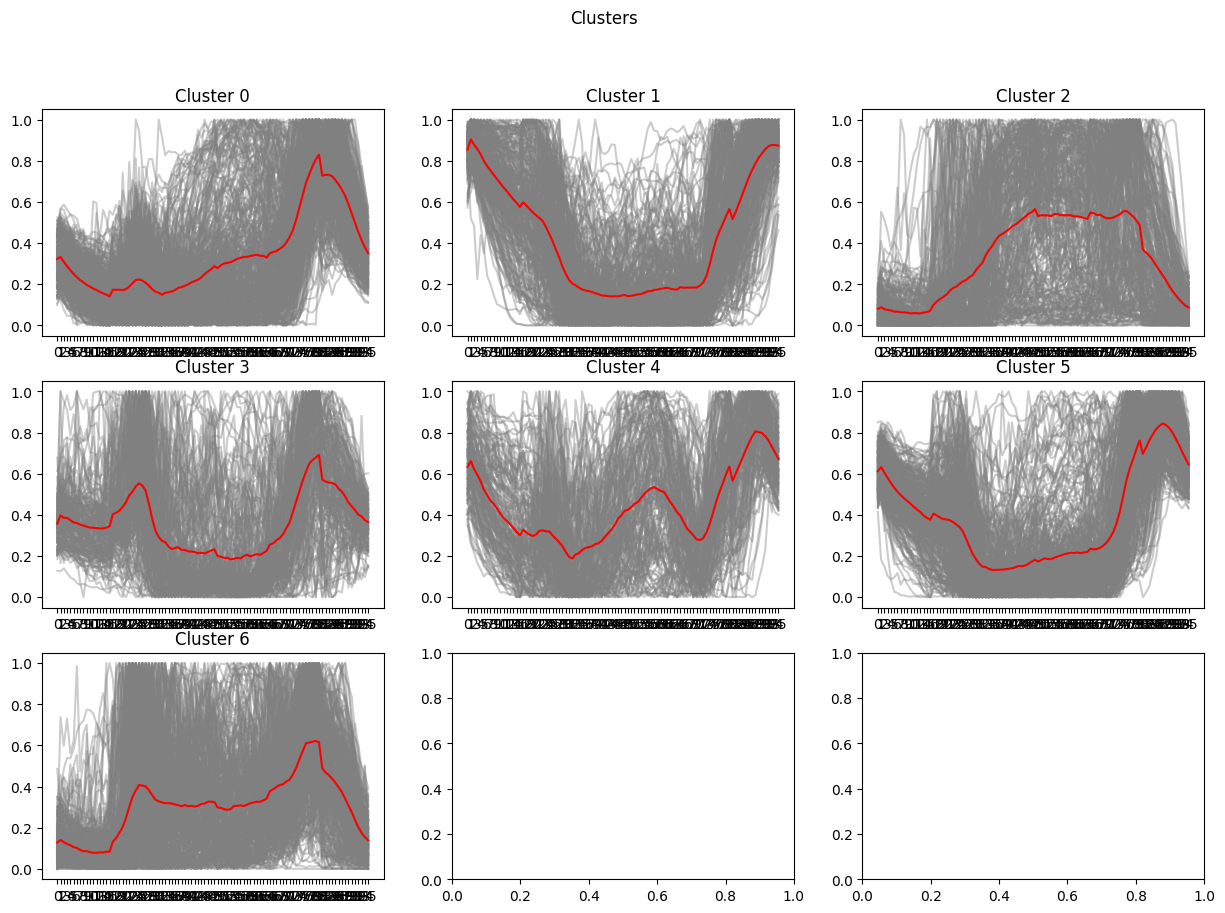

In [66]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Clusters')
row_i = 0
column_j = 0

for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if(labels[i] == label):
            axs[row_i, column_j].plot(df_test.iloc[i], c="gray", alpha=0.4)
            cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*3+column_j))
    column_j += 1
    if column_j % 3 == 0:
        row_i += 1
        column_j = 0

plt.show()

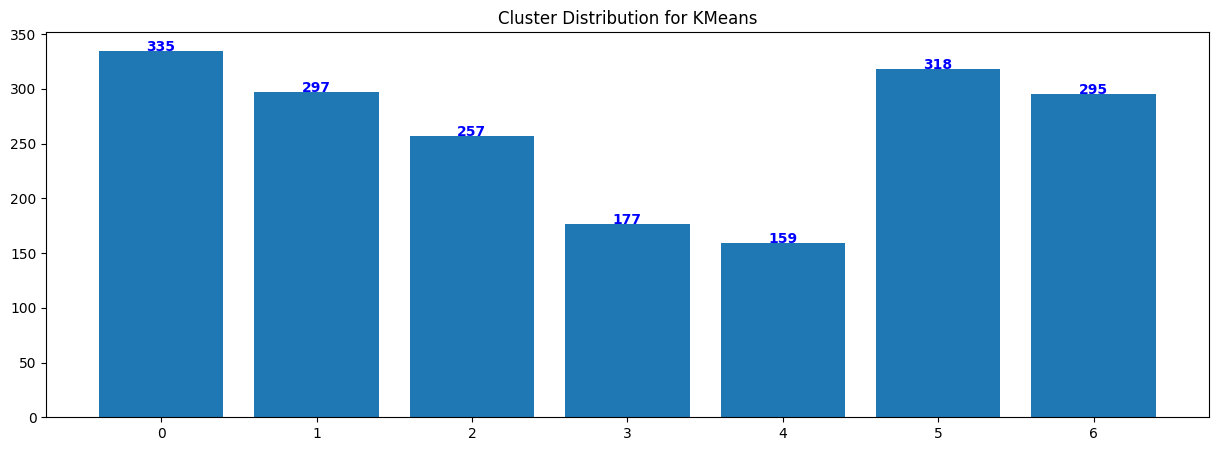

In [67]:
# Cluster Distribution
cluster_c = [len(labels[labels==i]) for i in range(7)]
# cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
cluster_n = [str(i) for i in range(7)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
for i, v in enumerate(cluster_c):
    plt.text(i, v, str(v), color='blue', fontweight='bold', ha='center')
plt.show()

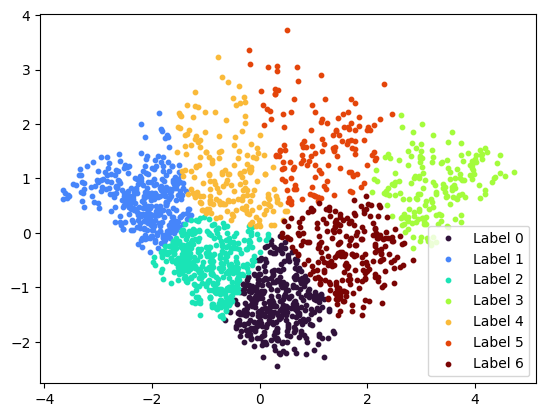

In [75]:
# Curse of Dimensionality

pca = PCA(n_components=2)
mySeries_transformed = pca.fit_transform(df_test)

kmeans = KMeans(n_clusters=7, max_iter=5000)
labels = kmeans.fit_predict(mySeries_transformed)

# Create a list of unique labels
unique_labels = list(set(labels))

# Set the colormap to match the number of labels
cmap = plt.cm.get_cmap('turbo', len(unique_labels))

# Plot each label separately with a different color and a label string
for i, label in enumerate(unique_labels):
    plt.scatter(mySeries_transformed[labels == label, 0], mySeries_transformed[labels == label, 1],
                c=cmap(i), s=10, label="Label {}".format(label))

# Add a legend to the plot
plt.legend()
plt.show()

### Saving the model

In [13]:
# import pickle

# with open("model/timeserieskmeans_model.pkl", "wb") as f:
#     pickle.dump(km, f)

### Loading the model

In [14]:
# with open("model/timeserieskmeans_model.pkl", "rb") as f:
#     model = pickle.load(f)

## Cluster Mapping

In [97]:
# We selected K=5
km = TimeSeriesKMeans(n_clusters=5, metric="dtw", n_jobs=-1, random_state=42)

labels = km.fit_predict(df_test)  #Index of the cluster each sample belongs to.

print("Inertia (5 clusters):", km.inertia_)

ss = silhouette_score(df_test, km.labels_)
print("Silhouette Score (5 clusters):", ss)

Inertia (5 clusters): 0.4178460146679835
Silhouette Score (5 clusters): 0.06206397604611428


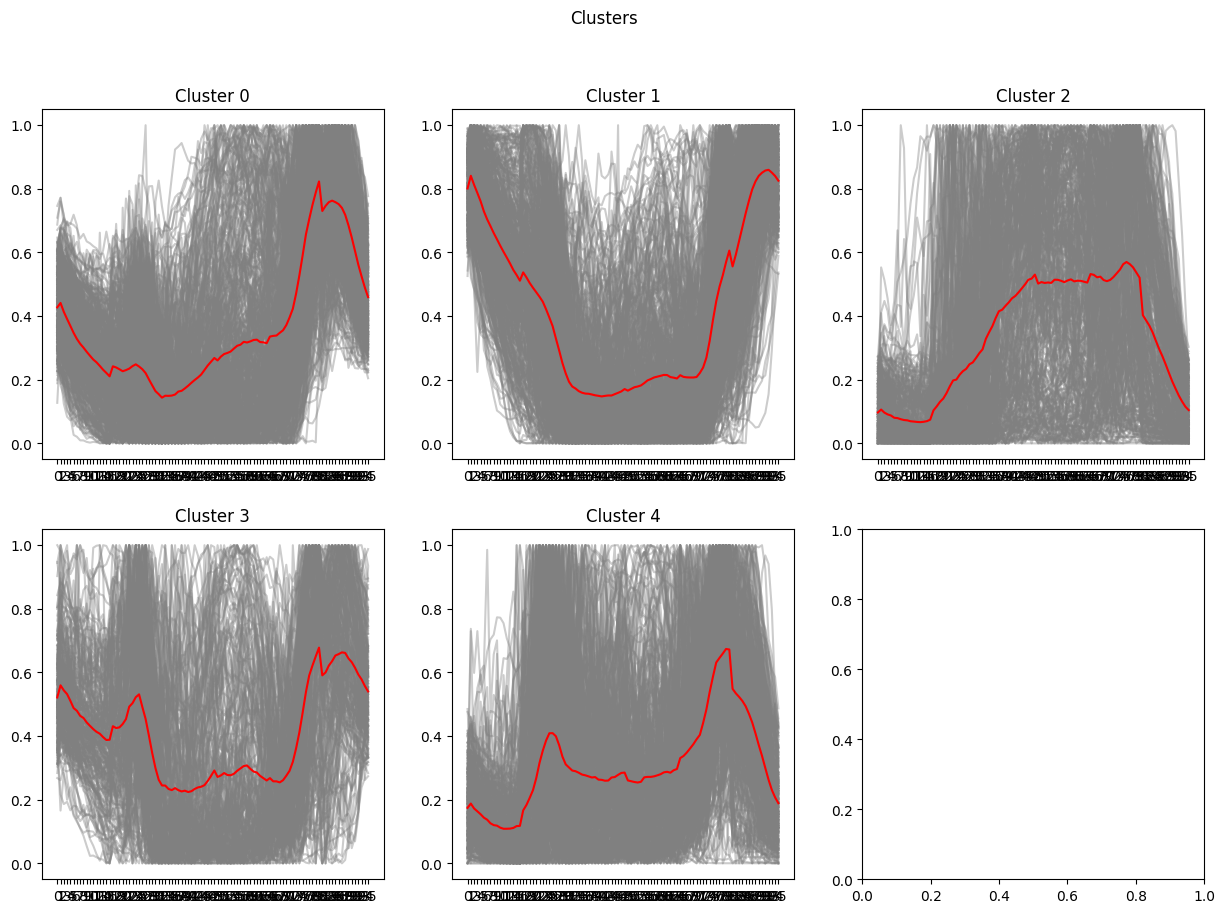

In [98]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Clusters')
row_i = 0
column_j = 0

for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if(labels[i] == label):
            axs[row_i, column_j].plot(df_test.iloc[i], c="gray", alpha=0.4)
            cluster.append(df_test.iloc[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*3+column_j))
    column_j += 1
    if column_j % 3 == 0:
        row_i += 1
        column_j = 0

plt.show()

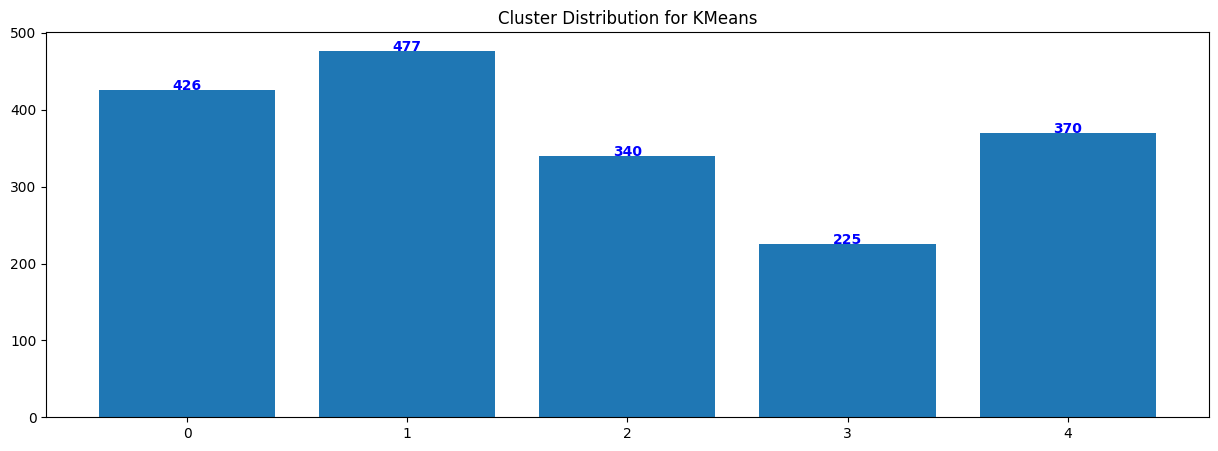

In [99]:
# Cluster Distribution
cluster_c = [len(labels[labels==i]) for i in range(5)]
# cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
cluster_n = [str(i) for i in range(5)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
for i, v in enumerate(cluster_c):
    plt.text(i, v, str(v), color='blue', fontweight='bold', ha='center')
plt.show()

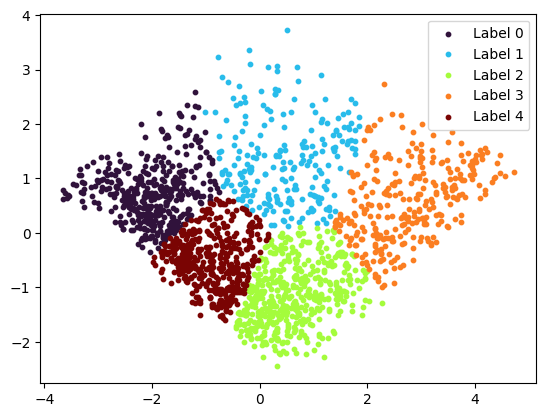

In [100]:
# Curse of Dimensionality

pca = PCA(n_components=2)
mySeries_transformed = pca.fit_transform(df_test)

kmeans = KMeans(n_clusters=5, max_iter=500)
labels_pca = kmeans.fit_predict(mySeries_transformed)

# Create a list of unique labels
unique_labels = list(set(labels_pca))

# Set the colormap to match the number of labels
cmap = plt.cm.get_cmap('turbo', len(unique_labels))

# Plot each label separately with a different color and a label string
for i, label in enumerate(unique_labels):
    plt.scatter(mySeries_transformed[labels_pca == label, 0], mySeries_transformed[labels_pca == label, 1],
                c=cmap(i), s=10, label="Label {}".format(label))

# Add a legend to the plot
plt.legend()
plt.show()

In [103]:
set(labels)

{0, 1, 2, 3, 4}

In [104]:
namesofMySeries = df_test.reset_index()['user'].to_list()

In [105]:
print(len(namesofMySeries))
namesofMySeries[:5]

1838


[0, 1, 2, 3, 4]

In [114]:
fancy_names_for_labels = [f"{label}" for label in labels]

In [115]:
print(len(fancy_names_for_labels))
fancy_names_for_labels[:5]

1838


['1', '2', '2', '2', '2']

In [116]:
# fancy_names_for_labels = [f"Cluster {label}" for label in labels]
groups_of_cluster = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

In [120]:
# Check the number of each clusters
print("The number of Cluster 0 : ", len(groups_of_cluster[groups_of_cluster['Cluster']== '0']))
print("The number of Cluster 1 : ", len(groups_of_cluster[groups_of_cluster['Cluster']== '1']))
print("The number of Cluster 2 : ", len(groups_of_cluster[groups_of_cluster['Cluster']== '2']))
print("The number of Cluster 3 : ", len(groups_of_cluster[groups_of_cluster['Cluster']== '3']))
print("The number of Cluster 4 : ", len(groups_of_cluster[groups_of_cluster['Cluster']== '4']))

The number of Cluster 0 :  426
The number of Cluster 1 :  477
The number of Cluster 2 :  340
The number of Cluster 3 :  225
The number of Cluster 4 :  370


In [125]:
# Selected each clusters
cluster_0 = groups_of_cluster[groups_of_cluster['Cluster'].isin(['0'])].reset_index()
cluster_1 = groups_of_cluster[groups_of_cluster['Cluster'].isin(['1'])].reset_index()
cluster_2 = groups_of_cluster[groups_of_cluster['Cluster'].isin(['2'])].reset_index()
cluster_3 = groups_of_cluster[groups_of_cluster['Cluster'].isin(['3'])].reset_index()
cluster_4 = groups_of_cluster[groups_of_cluster['Cluster'].isin(['4'])].reset_index()

In [126]:
# Save to csv
cluster_0.to_csv('datasets/cluster_0.csv', index=False)
cluster_1.to_csv('datasets/cluster_1.csv', index=False)
cluster_2.to_csv('datasets/cluster_2.csv', index=False)
cluster_3.to_csv('datasets/cluster_3.csv', index=False)
cluster_4.to_csv('datasets/cluster_4.csv', index=False)
print('Saved successfully')

Saved successfully
